In [38]:
import re
import os
import pathlib
import json
from typing import List, TypedDict

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings

warnings.simplefilter(action="ignore")
sns.set_theme(style="darkgrid")

%matplotlib inline

In [39]:
experiment = "02_http_constant_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()


In [40]:
"""
Clean the obtained results from the experiments
- Remove unnecessary columns
- Extract metadata from filenames
- Construct and clean data into a pandas.Series object
- Convert data measures in seconds to ms
"""

# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "ActualQPS",
    "DurationHistogram",
]


# fortio reports in seconds, convert to miliseconds
multiplier = 1000


# Regex to extract metadata
# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

"""
Reads a fortio results JSON file, cleans the data and returns
it as a pandas.Series
"""
def clean_fortio_results(results_file: pathlib.Path) -> pd.Series :
    # Read the JSON file as pandas series
    s = pd.read_json(results_file, typ="series")

    # Filter unnecesary columns
    s = s[required_cols]

    # Extract metadata from filename and add it to the series
    matches = re.match(name_re, str(results_file.name))
    s["mesh"] = matches[2]
    s["payload"] = matches[4]

    # Extract nested columns in 'DurationHistogram'
    for key, val in s["DurationHistogram"].items():
        s[key] = val
    s = s.drop(["DurationHistogram", "Percentiles"])

    # Convert obervations from seconds to miliseconds
    s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

    # Construct Histogram Bins, Counts and Percentiles
    data = s["Data"]

    s["counts"] = [x["Count"] for x in data]
    s["percentages"] = [x["Percent"] for x in data]

    # Bins (default pd.cut function makes them as categoricals of intervals)
    # https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
    # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
    s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
    s["bins"] = [x.left for x in s["categories"]]
    s["bins"].append(s["categories"][-1].right)

    return s


In [41]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""

series = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip resource usage files
        if not re.match("^(http|grpc).*\.json$", file):
            continue

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        res = clean_fortio_results(p)
        series.append(res)

df = pd.DataFrame(series)

# Re-order
df = df[[
    "mesh",
    "RequestedQPS",
    "payload",
    "ActualQPS",
    "StartTime",
    "Count",
    "Min",
    "Max",
    "Sum",
    "Avg",
    "StdDev",
    "counts",
    "percentages",
    "categories",
    "bins",
    "Data"
]]

# Sort
df = df.sort_values(by=["mesh", "RequestedQPS", "payload"], ignore_index=True)
df.head()

Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 60


,mesh,RequestedQPS,payload,ActualQPS,StartTime,Count,Min,Max,Sum,Avg,StdDev,counts,percentages,categories,bins,Data
0,baseline,1,0,0.966556,2022-06-26T14:46:59.012527933Z,896,0.212188,102.731670,1090.429308,1.216997,0.004302,"[3, 19, 6, 10, 60, 93, 186, 203, 147, 78, 51, ...","[0.33482142857142805, 2.4553571428571432, 3.12...","[(0.21218800000000002, 0.30000000000000004], (...","[0.21218800000000002, 0.30000000000000004, 0.4...","[{'Start': 0.000212188, 'End': 0.0003000000000..."
1,baseline,100,0,99.965428,2022-06-26T15:02:26.350225271Z,89984,0.123825,113.601389,40212.086436,0.446880,0.002561,"[271, 55759, 28699, 3111, 474, 194, 135, 94, 7...","[0.301164651493598, 62.26662517780939, 94.1600...","[(0.12382500000000002, 0.2], (0.2, 0.300000000...","[0.12382500000000002, 0.2, 0.30000000000000004...","[{'Start': 0.00012382500000000001, 'End': 0.00..."
2,baseline,1000,0,996.002446,2022-06-26T15:32:27.217672014Z,896434,0.067191,163.404687,266776.385544,0.297597,0.002158,"[2109, 706876, 141085, 15371, 5957, 3760, 2416...","[0.23526550755549203, 79.0894812111098, 94.827...","[(0.067191, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.067191, 0.1, 0.2, 0.30000000000000004, 0.4,...","[{'Start': 6.7191e-05, 'End': 0.0001, 'Percent..."
3,baseline,500,0,499.109653,2022-06-26T15:17:26.827088196Z,449214,0.083856,121.101064,162487.939908,0.361716,0.002697,"[11, 283375, 142667, 9830, 2456, 1184, 712, 51...","[0.0024487215447420003, 63.08485487985681, 94....","[(0.083856, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.083856, 0.1, 0.2, 0.30000000000000004, 0.4,...","[{'Start': 8.3856e-05, 'End': 0.0001, 'Percent..."
4,cilium,1,0,0.966557,2022-06-27T11:51:24.96285821Z,896,0.346019,98.937129,1574.957759,1.757765,0.003515,"[5, 8, 9, 5, 1, 5, 8, 20, 182, 336, 183, 62, 3...","[0.5580357142857141, 1.450892857142857, 2.4553...","[(0.346019, 0.4], (0.4, 0.5], (0.5, 0.60000000...","[0.346019, 0.4, 0.5, 0.6000000000000001, 0.7, ...","[{'Start': 0.00034601900000000004, 'End': 0.00..."


In [42]:
"""
Recreate underlying distribution of aggregated data by sampling.
"""

def sample_aggregated_data(binned_data: pd.DataFrame) -> np.ndarray:
    """Samples Histogram data to recreate underlying distribution.
    
    @arg
    binned_data: list of bins, half-open interval [Start, End)
    Start: bin start (including)
    End: bin end (excluding)
    Count: count of observations in bin
    """

    samples = []

    for bin in binned_data:
        low = bin["Start"]
        high = bin["End"]
        size = bin["Count"]
        samples.append(np.random.uniform(low=low, high=high, size=size))

    sampled_data = np.concatenate(samples)

    # Convert latency in seconds to ms
    sampled_data = sampled_data * 1000

    return sampled_data

In [43]:
"""
Creates a table of latency results
Each row contains the results for a given mesh config by RPS
Latency values are presented in a single value
"""

results = []
for i, row in df.iterrows():
    sampled_data = sample_aggregated_data(row["Data"])

    obs = {
        "mesh": row["mesh"].capitalize(),
        "qps": row["RequestedQPS"],
        "latency": sampled_data,
    }
    results.append(obs)

sampled_df = pd.DataFrame(results)
sampled_df.head()


,mesh,qps,latency
0,Baseline,1,"[0.2954094352227907, 0.25233827566420586, 0.24..."
1,Baseline,100,"[0.19368938000690017, 0.17232210479886945, 0.1..."
2,Baseline,1000,"[0.09768780584741868, 0.0951900287142681, 0.09..."
3,Baseline,500,"[0.09051061863841775, 0.0881456245505147, 0.09..."
4,Cilium,1,"[0.3519289401030352, 0.35544633067927645, 0.36..."


In [44]:
"""
Converts the table format
Each row now contains a single latency observation from the sampled data
"""

# Expand the list of values to individual rows
df = sampled_df.explode("latency")

# Explicitely set types
df["mesh"] = df["mesh"].astype("category")
df["qps"] = df["qps"].astype("category")
df["latency"] = pd.to_numeric(df["latency"])

df.head()

,mesh,qps,latency
0,Baseline,1,0.295409
0,Baseline,1,0.252338
0,Baseline,1,0.244820
0,Baseline,1,0.342961
0,Baseline,1,0.324103


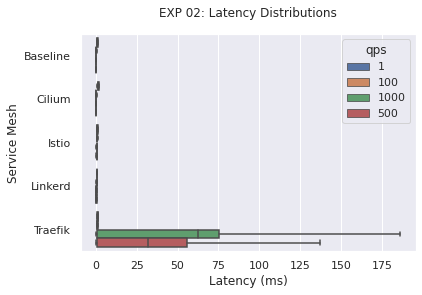

In [45]:
"""
PLOT: Boxplot latency by mesh
"""

file_name = "exp_02-latency-boxplot.pdf"
plot_title = "EXP 02: Latency Distributions"

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="latency", y="mesh", hue="qps", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

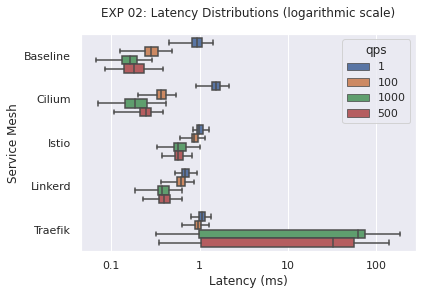

In [46]:
"""
PLOT: Boxplot latency by mesh (log scale)
"""

file_name = "exp_02-latency-boxplot-log.pdf"
plot_title = "EXP 02: Latency Distributions (logarithmic scale)"

fig, ax = plt.subplots()
ax = sns.boxplot(data=df, x="latency", y="mesh", hue="qps", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)

ax.set_xscale("log")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

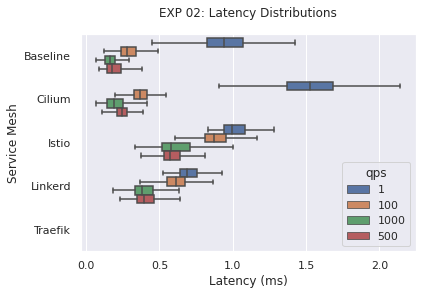

In [47]:

"""
PLOT: Boxplot latency by mesh (no Traefik)
"""

file_name = "exp_02-latency-boxplot-no-traefik.pdf"
plot_title = "EXP 02: Latency Distributions"

# Removes Traefik mesh rows
data = df[df["mesh"] != "Traefik"]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", hue="qps", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

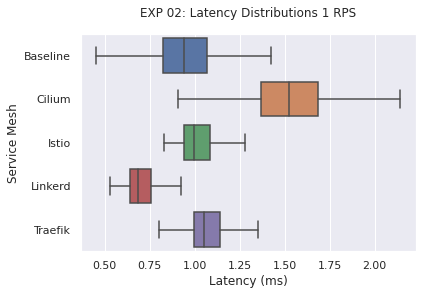

In [48]:
"""
PLOT: Latency by mesh - 1 QPS
"""

qps = "1"
file_name = f"exp_02-latency-boxplot_{qps}.pdf"
plot_title = f"EXP 02: Latency Distributions {qps} RPS"


# Subset data
data = df[df["qps"] == qps]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

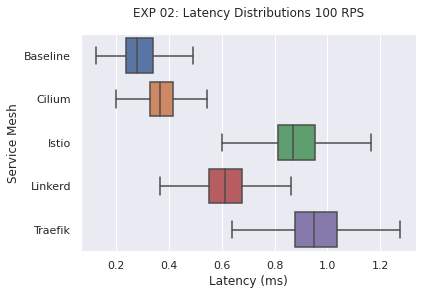

In [49]:

"""
PLOT: Latency by mesh - 100 QPS
"""

qps = "100"
file_name = f"exp_02-latency-boxplot_{qps}.pdf"
plot_title = f"EXP 02: Latency Distributions {qps} RPS"


# Subset data
data = df[df["qps"] == qps]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

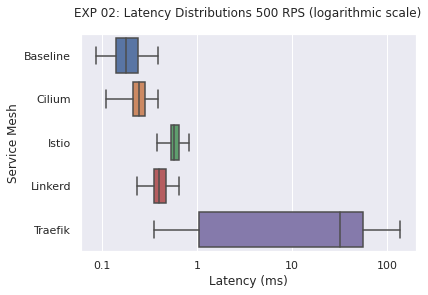

In [50]:

"""
PLOT: Latency by mesh - 500 QPS (log)
"""

qps = "500"
file_name = f"exp_02-latency-boxplot_{qps}.pdf"
plot_title = f"EXP 02: Latency Distributions {qps} RPS (logarithmic scale)"


# Subset data
data = df[df["qps"] == qps]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)

ax.set_xscale("log")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

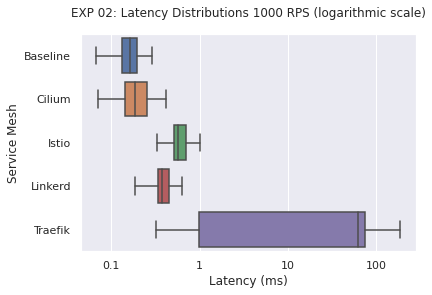

In [51]:

"""
PLOT: Latency by mesh - 1000 QPS (log)
"""

qps = "1000"
file_name = f"exp_02-latency-boxplot_{qps}.pdf"
plot_title = f"EXP 02: Latency Distributions {qps} RPS (logarithmic scale)"


# Subset data
data = df[df["qps"] == qps]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)

ax.set_xscale("log")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()

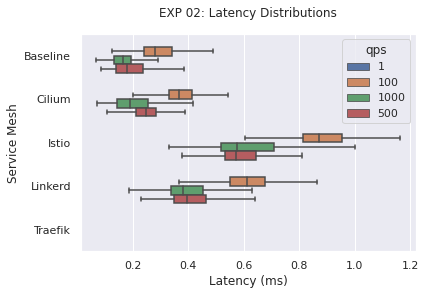

In [53]:
"""Comparison without Traefik"""

file_name = "exp_02-latency-boxplot-no-traefik_v2.pdf"
plot_title = "EXP 02: Latency Distributions"

# Removes Traefik mesh rows
data = df[df["mesh"] != "Traefik"]

fig, ax = plt.subplots()
ax = sns.boxplot(data=data, x="latency", y="mesh", hue="qps", showfliers=False)

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Latency (ms)")
ax.set_title(plot_title, y=1.05)


# Save figure to disk
fig.savefig(plot_dir / file_name)

plt.show()